# SkyCaptions

SkyCaptions generates captions for satellite images using Bidirectional Long Short-Term Memory (BiLSTM) networks and the Vision Transformer (ViT) feature extractor. This combination allows for effective extraction of image features and sequential modeling of captions.

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install tensorflow-addons

In [ ]:
!pip install keras-vit

In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import re
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dropout, Flatten, Dense, Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


IMG_SIZE = 224
BATCH_SIZE = 64
SEED = 10
AUTO = tf.data.AUTOTUNE

In [ ]:
from keras_vit.vit import ViT_B16

In [ ]:
image_path = '/kaggle/input/satellite-image-caption-generation/'

train_data = pd.read_csv("/kaggle/input/satellite-image-caption-generation/train.csv")
train_data['filepath'] = image_path + train_data['filepath']

valid_data = pd.read_csv("/kaggle/input/satellite-image-caption-generation/valid.csv")
valid_data['filepath'] = image_path + valid_data['filepath']

test_data = pd.read_csv("/kaggle/input/satellite-image-caption-generation/test.csv")
test_data['filepath'] = image_path + test_data['filepath']

# <span style="color:#e74c3c;"> Text </span> Preprocessing

In [ ]:
# the first stage
def text_preprocessing(data):
    data['captions'] = data['captions'].apply(lambda x: x.replace("["," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("]"," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("''"," "))
    data['captions'] = data['captions'].apply(lambda x: x.lower())
    data['captions'] = data['captions'].apply(lambda x: x.replace("[^A-Za-z]"," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("\s+"," "))
    data['captions'] = data['captions'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

    return data

# splitting each caption (due to one image has many captions)
def splitting_captions(df):
    captions_arr = []
    filepaths_arr = []

    for i in range(df.shape[0]):
        img = df['filepath'].values[i]
        captions = re.split(r"' '", df['captions'].values[i])
        for caption in captions:
            captions_arr.append(caption)
            filepaths_arr.append(img)

    data = pd.DataFrame({'captions': captions_arr, 'filepath': filepaths_arr})

    return data

# the last stage and
def last_preprocessing(data):
    data['captions'] = data['captions'].apply(lambda x: x.replace("'",""))
    data['captions'] = data['captions'].apply(lambda x: x.replace(".",""))
    data['captions'] = "startseq "+data['captions']+" endseq"

    return data

In [ ]:
# Applying text preprocessing functions

train_data_preprocessed = text_preprocessing(train_data)
train_data_preprocessed = splitting_captions(train_data_preprocessed)
train_data_new = last_preprocessing(train_data_preprocessed)

valid_data_preprocessed = text_preprocessing(valid_data)
valid_data_preprocessed = splitting_captions(valid_data_preprocessed)
valid_data_new = last_preprocessing(valid_data_preprocessed)

test_data_preprocessed = text_preprocessing(test_data)
test_data_preprocessed = splitting_captions(test_data_preprocessed)
test_data_new = last_preprocessing(test_data_preprocessed)


print('train shape -> ', train_data_new.shape[0])
print('valid shape -> ', valid_data_new.shape[0])
print('test shape -> ', test_data_new.shape[0])

train shape ->  41206
valid shape ->  5147
test shape ->  5203


In [ ]:
# an example of training caption
train_data_new.iloc[SEED].captions

'startseq many aircraft are parked in an airport near many runways endseq'

# <span style="color:#e74c3c;"> Caption </span> Tokenization

In [ ]:
captions = train_data_new['captions'].tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

train_images = train_data_new['filepath'].unique().tolist()
train = train_data_preprocessed[train_data_preprocessed['filepath'].isin(train_images)]
train.reset_index(inplace=True,drop=True)

valid_images = valid_data_new['filepath'].unique().tolist()
valid = valid_data_preprocessed[valid_data_preprocessed['filepath'].isin(valid_images)]
valid.reset_index(inplace=True,drop=True)

test_images = test_data_new['filepath'].unique().tolist()
test = test_data_preprocessed[test_data_preprocessed['filepath'].isin(test_images)]
test.reset_index(inplace=True,drop=True)
tokenizer.texts_to_sequences([captions[SEED]])[0]

[1, 5, 189, 3, 48, 10, 26, 55, 16, 5, 234, 2]

# <span style="color:#e74c3c;"> ViT </span> Feature Extractor

In [ ]:
vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', weights="imagenet21k+imagenet2012",
                        pretrained = True, include_top = True, pretrained_top = True)

feature_extractor = Model(inputs=vit_model.input, outputs=vit_model.layers[-2].output)

347502902/347502902 [==============================] - 1s 0us/step


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [ ]:
# Reading -> Resizing -> Normalization
def img_preprocessing(img, caption):
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    # 9999 is a null class
    return img, 9999

In [ ]:
# Creating dataset loader and tf.datasets
train_loader_for_img_features = tf.data.Dataset.from_tensor_slices((train['filepath'], train['captions']))
train_dataset_for_img_features = (train_loader_for_img_features
                                  .map(img_preprocessing, num_parallel_calls = AUTO)
                                  .batch(BATCH_SIZE)
                                  .prefetch(AUTO))


valid_loader_for_img_features = tf.data.Dataset.from_tensor_slices((valid['filepath'], valid['captions']))
valid_dataset_for_img_features = (valid_loader_for_img_features
                                  .map(img_preprocessing, num_parallel_calls = AUTO)
                                  .batch(BATCH_SIZE)
                                  .prefetch(AUTO))


test_loader_for_img_features = tf.data.Dataset.from_tensor_slices((test['filepath'], test['captions']))
test_dataset_for_img_features = (test_loader_for_img_features
                                 .map(img_preprocessing, num_parallel_calls = AUTO)
                                 .batch(BATCH_SIZE)
                                 .prefetch(AUTO))

In [ ]:
def create_img_feature_dict(feature_extractor_model, tf_dataset, df):
    img_features = feature_extractor_model.predict(tf_dataset)
    features_dict = {}

    assert df.shape[0] == img_features.shape[0]
    for i in range(df.shape[0]):
        img_feature = tf.expand_dims(img_features[i], axis=0)
        features_dict[df['filepath'].iloc[i]] = img_feature

    return features_dict

In [ ]:
# creating image features
train_img_features = create_img_feature_dict(feature_extractor, train_dataset_for_img_features, train)
valid_img_features = create_img_feature_dict(feature_extractor, valid_dataset_for_img_features, valid)
test_img_features = create_img_feature_dict(feature_extractor, test_dataset_for_img_features, test)

82/82 [==============================] - 38s 458ms/step


# <span style="color:#e74c3c;"> Creating </span> Sequence Generator

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True, **kwargs):
        super(CustomDataGenerator, self).__init__(**kwargs)
        self.df = df.copy()
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch['filepath'].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch['filepath']== image, 'captions'].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)


        return X1, X2, y

In [ ]:
# creating generators
train_generator = CustomDataGenerator(df = train_data_new, batch_size = BATCH_SIZE, tokenizer = tokenizer,vocab_size = vocab_size,
                                      max_length = max_length, features = train_img_features)

valid_generator = CustomDataGenerator(df = valid_data_new,batch_size = BATCH_SIZE, tokenizer=tokenizer,vocab_size=vocab_size,
                                      max_length = max_length, features = valid_img_features, shuffle = False)


test_generator = CustomDataGenerator(df = test_data_new, batch_size = BATCH_SIZE, tokenizer = tokenizer, vocab_size=vocab_size,
                                     max_length = max_length, features = test_img_features, shuffle = False)

# <span style="color:#e74c3c;"> Creating </span> Sequence Generator

In [ ]:
input1 = Input(shape=(768,))
input2 = Input(shape=(max_length,))

img_features = Dense(512, activation='relu')(input1)
img_features_reshaped = Reshape((1, 512), input_shape=(512,))(img_features)

sentence_features = Embedding(vocab_size, 512, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = Bidirectional(LSTM(256, dropout=0.1))(merged)

X = Dropout(0.5)(sentence_features)
X = add([X, img_features])
X = Dense(128, activation='relu')(X)
X = Dropout(0.5)(X)
output = Dense(vocab_size, activation='softmax')(X)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',
                          optimizer=tf.optimizers.AdamW(learning_rate=0.001, weight_decay=0.004))

caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 512)                  393728    ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 53)]                 0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 1, 512)               0         ['dense[0][0]']               
                                                                                            

In [ ]:
# training
hist = caption_model.fit(train_generator,epochs = 10, validation_data = valid_generator,
                         callbacks = [EarlyStopping(monitor='val_loss', min_delta = 0, patience = 2, restore_best_weights = True)])

Epoch 1/10
643/643 [==============================] - 314s 479ms/step - loss: 3.5518 - val_loss: 2.6649
Epoch 2/10
643/643 [==============================] - 93s 145ms/step - loss: 2.3072 - val_loss: 2.2909
Epoch 3/10
643/643 [==============================] - 87s 136ms/step - loss: 2.0356 - val_loss: 2.2288
Epoch 4/10
643/643 [==============================] - 87s 135ms/step - loss: 1.8953 - val_loss: 2.2191
Epoch 5/10
643/643 [==============================] - 87s 135ms/step - loss: 1.8008 - val_loss: 2.2146
Epoch 6/10
643/643 [==============================] - 86s 133ms/step - loss: 1.7290 - val_loss: 2.2304
Epoch 7/10
643/643 [==============================] - 86s 134ms/step - loss: 1.6700 - val_loss: 2.2434


In [ ]:
# test evaluation
test_eval = caption_model.evaluate(test_generator)

81/81 [==============================] - 24s 297ms/step - loss: 3.0214


In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None


# prediction function
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred_ = model.predict([feature,sequence], verbose = 0)
        y_pred = np.argmax(y_pred_)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word
        if word == 'endseq':
            break

    return in_text, y_pred_, y_pred

# <span style="color:#e74c3c;"> Test </span> Predictions

In [ ]:
# 50 random samples from test dataset
samples = test.sample(50)
samples.reset_index(drop=True,inplace=True)

# test predictions
for index,record in samples.iterrows():
    image_path = image_path + '/'

    img = load_img(os.path.join(image_path,record['filepath']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['filepath'], tokenizer, max_length, test_img_features)
    samples.loc[index,'captions'] = caption

In [ ]:
# a function for displaying a sample, true captions and theprediction caption

def display_prediction_images(temp_df, SEED):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (5,5))

    idx = np.random.default_rng(seed=SEED).permutation(temp_df.shape[0])[0]
    img = cv2.imread(temp_df.iloc[idx]['filepath'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    true_captions = test.loc[test['filepath']== temp_df.filepath[idx], 'captions'].tolist()[:3]

    pred_caption = temp_df.iloc[idx]['captions'][0]
    pred_caption = pred_caption.replace('startseq ', ' ')
    pred_caption = pred_caption.replace(' endseq', ' ')


    for true_caption in true_captions:
        true_caption = true_caption.replace('startseq ', ' ')
        true_caption = true_caption.replace(' endseq', ' ')
        print("TRUE : " +true_caption + '\n')


    print( "PRED : "+ pred_caption)


    plt.imshow(img)
    plt.axis('off')

TRUE :  "theres wavy pattern on the golden desert" there is wavy pattern on the golden desert  

TRUE :  the desert is glistening with some complex texture  

TRUE :  it is spectacular twinkling desert with wrinkles  

PRED :  many undulations are in piece of yellow desert 


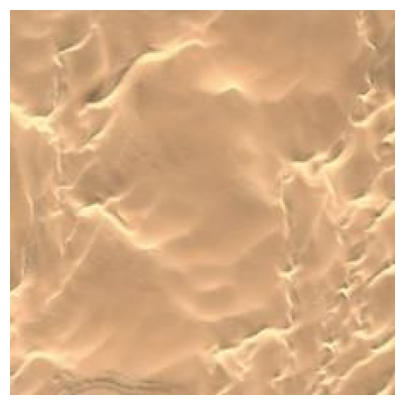

In [ ]:
display_prediction_images(samples, 89)

TRUE :  among the forest four houses with three swimming pools built on the coast 

TRUE :  between the forest four houses with three swimming pools built on the coast 

TRUE :  among forest four houses with three swimming pools built on the coast  

PRED :  many green trees and some buildings are in resort with swimming pool 


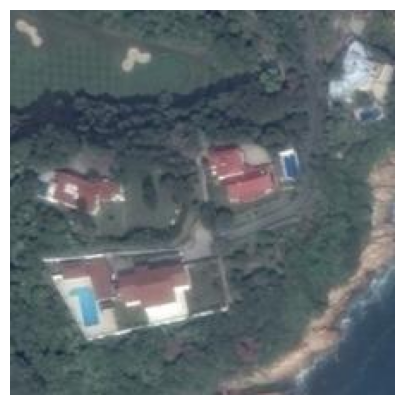

In [ ]:
display_prediction_images(samples, 30)

TRUE :  many large buildings were built on both sides of the road 

TRUE :  many trees are planted around buildings 

TRUE :  many trees are planted around the buildings  

PRED :  many buildings and some green trees are located in commercial area 


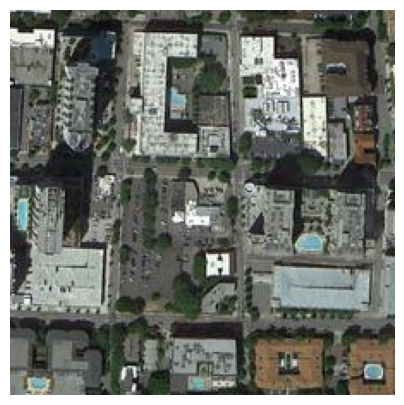

In [ ]:
display_prediction_images(samples, 100)

TRUE :  square parking and factory buildings are built on concrete with road through 

TRUE :  parking lots and square factory buildings are built on the concrete with road passing by  

TRUE :  the grey rectangle workshops are near the black ones  

PRED :  many buildings and some green trees are in an industrial area 


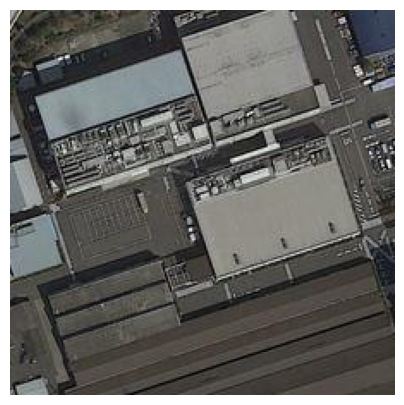

In [ ]:
display_prediction_images(samples, 438)